## Analysis of mutation prediction results

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot as up
from venn import generate_petal_labels

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
results_dir = os.path.join('results', 'univariate_fs', 'pancancer')

In [3]:
results_df = au.load_prediction_results_fs(results_dir, cfg.fs_methods)

results_df.loc[
    (results_df.fs_method == 'mad') & (results_df.n_dims == 100),
    'fs_method'
] = 'mad_100'
results_df.loc[
    (results_df.fs_method == 'mad') & (results_df.n_dims == 1000),
    'fs_method'
] = 'mad_1000'

print(results_df.shape)
print(results_df.fs_method.unique())
print(results_df.n_dims.unique())
results_df.head()

(1440, 10)
['median_f_test' 'mad_100' 'mad_1000' 'mad_f_test' 'pancan_f_test']
[ 100 1000]


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,fs_method,n_dims
0,0.55681,0.53291,TP53,NaN,shuffled,42,train,0,median_f_test,100
1,0.49419,0.46362,TP53,NaN,shuffled,42,test,0,median_f_test,100
2,0.51169,0.48608,TP53,NaN,shuffled,42,cv,0,median_f_test,100
3,0.54038,0.50844,TP53,NaN,shuffled,42,train,1,median_f_test,100
4,0.52547,0.49144,TP53,NaN,shuffled,42,test,1,median_f_test,100


In [4]:
compare_df = []
for fs_method in results_df.fs_method.unique():
    print(fs_method, file=sys.stderr)
    compare_df.append(
        au.compare_control_ind(results_df[results_df.fs_method == fs_method],
                               metric='aupr', verbose=True)
          .assign(fs_method=fs_method)
    )
compare_df = pd.concat(compare_df)

print(compare_df.shape)
compare_df.head()

median_f_test
mad_100
mad_1000
mad_f_test
pancan_f_test


(240, 5)


,identifier,seed,fold,delta_aupr,fs_method
0,APC,42,0,0.53778,median_f_test
1,APC,42,1,0.61413,median_f_test
2,APC,42,2,0.55923,median_f_test
3,APC,42,3,0.56890,median_f_test
4,APC,1,0,0.53763,median_f_test


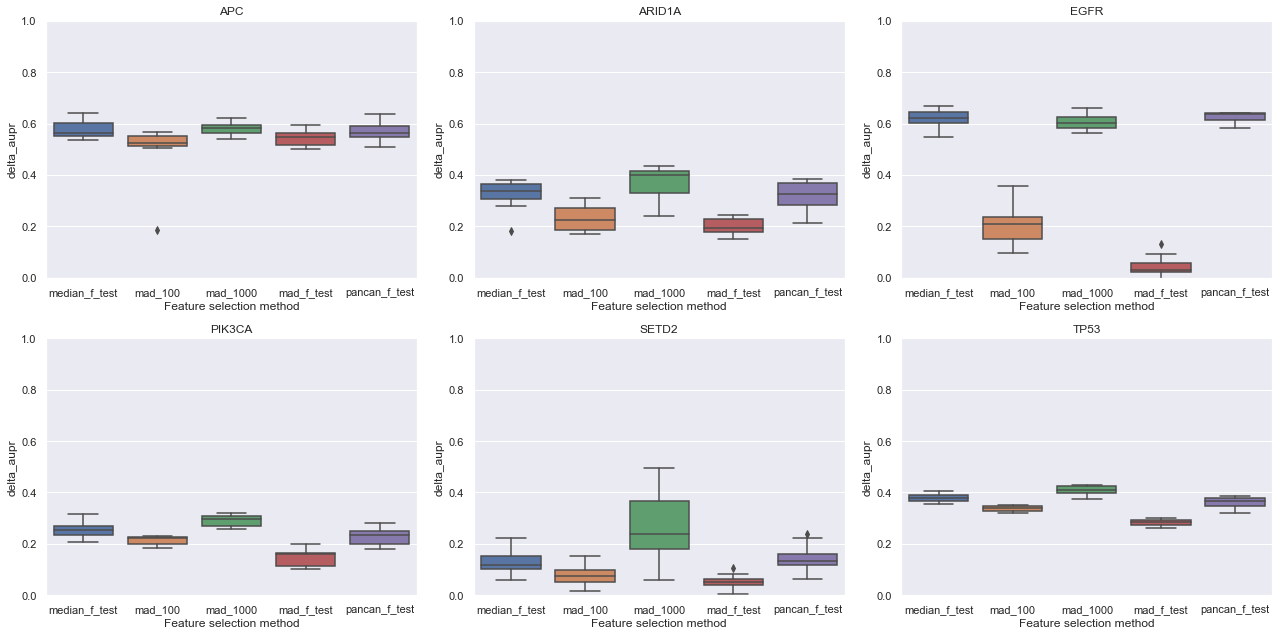

In [5]:
sns.set({'figure.figsize': (18, 9)})
sns.set_context('notebook')

fig, axarr = plt.subplots(2, 3)

for ix, gene in enumerate(compare_df.identifier.unique()):
    ax = axarr[ix // 3, ix % 3]
    plot_df = compare_df[compare_df.identifier == gene]
    sns.boxplot(data=plot_df, x='fs_method', y='delta_aupr', ax=ax)
    ax.set_title(gene)
    ax.set_xlabel('Feature selection method')
    ax.set_ylim(0, 1)

plt.tight_layout()

In [6]:
# analysis of selected features:
# overlap of features in at least one model
# f-statistic distributions for features in at least one model
# f-statistic distributions per fold

# gene to analyze features for
gene = 'TP53'

id_coefs_info = []
for identifier, coefs_list in au.generate_nonzero_coefficients_fs(
        results_dir, cfg.fs_methods):
    if not identifier.startswith(gene): continue
    for fold_no, coefs in enumerate(coefs_list):
        id_coefs_info.append([identifier, fold_no, coefs])
        
print(len(id_coefs_info))

40


In [7]:
print(len(id_coefs_info[0]))
print(id_coefs_info[0])

3
['TP53_mad_n100', 0, [('6490', -48.839), ('CESC', -10.332), ('OV', 4.6879), ('UCS', 2.6518), ('PAAD', 1.6652), ('BLCA', -1.21), ('log10_mut', 1.0676), ('LUAD', -0.8744), ('READ', 0.80921), ('HNSC', -0.78588), ('2023', 0.64835), ('6122', -0.53176), ('4627', 0.47179), ('64065', 0.43956999999999996), ('UCEC', -0.41885), ('3728', 0.39264), ('6222', 0.3911), ('12', -0.36707), ('ESCA', 0.36680999999999997), ('2752', -0.34245), ('2670', 0.33713000000000004), ('STAD', -0.33566999999999997), ('1191', -0.32795), ('63827', 0.3183), ('1938', -0.31626), ('6678', -0.3053), ('1278', 0.27712), ('3854', -0.26961999999999997), ('1832', -0.26254), ('629', -0.23788), ('26986', 0.23656), ('7178', -0.23283), ('348', 0.23258), ('335', -0.21043), ('3817', -0.2092), ('6439', -0.20898000000000003), ('2810', -0.2076), ('6132', 0.20713), ('5660', 0.2039), ('2597', -0.18273), ('3106', 0.17174), ('7431', -0.16660999999999998), ('100133941', 0.15582000000000001), ('972', -0.1554), ('3105', 0.14943), ('79026', -0.1

In [8]:
# list of sets, one for each feature selection method, of
# features that were selected in at least one cross-validation fold
fs_method_coefs = {}
for coefs_list in id_coefs_info:
    identifier = coefs_list[0]
    features = list(zip(*coefs_list[2]))[0]
    if identifier in fs_method_coefs:
        fs_method_coefs[identifier].update(features)
    else:
        fs_method_coefs[identifier] = set(features)
    
print(list(fs_method_coefs.keys()))

['TP53_mad_n100', 'TP53_mad_n1000', 'TP53_mad_f_test_n100', 'TP53_median_f_test_n100', 'TP53_pancan_f_test_n100']


In [9]:
print(len(fs_method_coefs['{}_mad_n100'.format(gene)]))
print(list(fs_method_coefs['{}_mad_n100'.format(gene)])[:5])

118
['2023', '1277', '1191', '71', '6696']


In [10]:
def series_from_samples(samples, labels):
    """Generate the weird dataframe format that Python upsetplot expects.
    
    Use as input lists of samples, and the labels that correspond
    to each list.
    """
    # use pyvenn to generate overlaps/labels from sample IDs
    venn_labels = generate_petal_labels(samples)
    # generate format upset plot package expects
    df_ix = [[(i == '1') for i in list(b)] + [int(v)] for b, v in venn_labels.items()]
    # generate dataframe from list
    rename_map = {ix: labels[ix] for ix in range(len(labels))}
    index_names = list(rename_map.values())
    rename_map[len(labels)] = 'id'
    df = (pd.DataFrame(df_ix)
        .rename(columns=rename_map)
        .set_index(index_names)
    )
    # and return as series
    return df['id']

In [11]:
upset_series = series_from_samples(
    list(fs_method_coefs.values()), list(fs_method_coefs.keys())
)
upset_series[upset_series != 0].sort_values(ascending=False).head(5)

TP53_mad_n100  TP53_mad_n1000  TP53_mad_f_test_n100  TP53_median_f_test_n100  TP53_pancan_f_test_n100
False          True            False                 False                    False                      498
                               True                  False                    False                      154
                               False                 True                     False                      147
                                                     False                    True                        64
True           True            False                 False                    False                       58
Name: id, dtype: int64

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

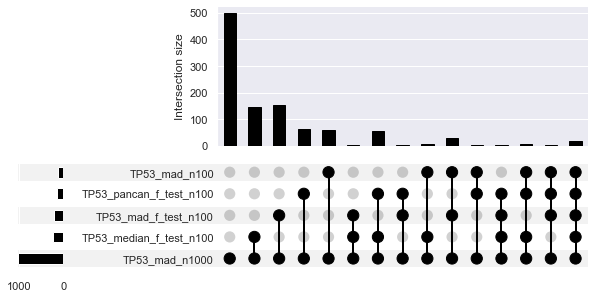

In [12]:
up.plot(upset_series[upset_series != 0])

In [13]:
fs_method_small = {
    k: v for k, v in fs_method_coefs.items() if 'mad_n1000' not in k
}
upset_series_small = series_from_samples(
    list(fs_method_small.values()), list(fs_method_small.keys())
)
upset_series_small[upset_series_small != 0].sort_values(ascending=False).head(5)

TP53_mad_n100  TP53_mad_f_test_n100  TP53_median_f_test_n100  TP53_pancan_f_test_n100
False          True                  False                    False                      154
               False                 True                     False                      147
                                     False                    True                        64
True           False                 False                    False                       58
False          False                 True                     True                        54
Name: id, dtype: int64

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

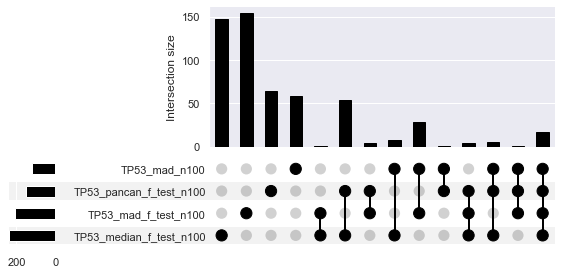

In [14]:
up.plot(upset_series_small[upset_series_small != 0])

In [15]:
# get distribution of univariate feature correlations
# NOTE these won't be exactly what was used for feature selection since
# we're not doing the same train/test splits here, we're just calculating
# on the whole dataset
# (this could be fixed but not sure it's worth the effort at the moment)

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif

import pancancer_evaluation.utilities.data_utilities as du

print('Loading gene label data...', file=sys.stderr)
genes_df = du.load_top_50()
sample_info_df = du.load_sample_info(verbose=True)

# this returns a tuple of dataframes, unpack it below
pancancer_data = du.load_pancancer_data(verbose=True)
(sample_freeze_df,
 mutation_df,
 copy_loss_df,
 copy_gain_df,
 mut_burden_df) = pancancer_data

rnaseq_df = du.load_expression_data(verbose=True)

# standardize columns of expression dataframe
print('Standardizing columns of expression data...', file=sys.stderr)
rnaseq_df[rnaseq_df.columns] = StandardScaler().fit_transform(rnaseq_df[rnaseq_df.columns])

Loading gene label data...
Loading sample info...
Loading pan-cancer data from cached pickle file...
Loading gene expression data...
Standardizing columns of expression data...


In [17]:
print(rnaseq_df.shape)
rnaseq_df.iloc[:5, :5]

(11060, 16148)


,1,10,100,1000,10000
sample_id,,,,,
TCGA-02-0047-01,-0.144100,-0.136450,-0.207065,1.049402,0.644625
TCGA-02-0055-01,-0.124925,-0.197893,-0.132694,0.704438,0.154763
TCGA-02-2483-01,-0.133543,-0.174587,-0.103291,1.473420,0.669303
TCGA-02-2485-01,-0.147052,-0.072888,-0.213119,4.405612,11.503035
TCGA-02-2486-01,-0.145321,-0.181076,-0.147395,1.013468,0.117745


In [18]:
y_df = (mutation_df
    .loc[:, [gene]]
    .merge(sample_freeze_df, left_index=True, right_on='SAMPLE_BARCODE')
    .drop(columns='PATIENT_BARCODE')
    .set_index('SAMPLE_BARCODE')
    .rename(columns={gene: 'status',
                     'DISEASE': 'cancer_type',
                     'SUBTYPE': 'subtype'})
)
display(y_df.shape, y_df.head())

(9074, 3)

,status,cancer_type,subtype
SAMPLE_BARCODE,,,
TCGA-02-0047-01,0,GBM,IDHwt
TCGA-02-0055-01,1,GBM,IDHwt
TCGA-02-2483-01,1,GBM,IDHmut-non-codel
TCGA-02-2485-01,1,GBM,IDHwt
TCGA-02-2486-01,0,GBM,IDHwt


In [19]:
X_df = rnaseq_df.reindex(y_df.index)

# make sure we didn't introduce any NA rows
assert X_df.isna().sum().sum() == 0

display(X_df.shape,
        X_df.isna().sum().sum(),
        X_df.iloc[:5, :5])

(9074, 16148)

0

,1,10,100,1000,10000
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,-0.144100,-0.136450,-0.207065,1.049402,0.644625
TCGA-02-0055-01,-0.124925,-0.197893,-0.132694,0.704438,0.154763
TCGA-02-2483-01,-0.133543,-0.174587,-0.103291,1.473420,0.669303
TCGA-02-2485-01,-0.147052,-0.072888,-0.213119,4.405612,11.503035
TCGA-02-2486-01,-0.145321,-0.181076,-0.147395,1.013468,0.117745


In [20]:
def get_f_stats_for_cancer_types(X_df, y_df):
    f_stats_df = {
        'pancan': f_classif(X_df, y_df.status)[0]
    }
    for cancer_type in y_df.cancer_type.unique():
        ct_samples = y_df[y_df.cancer_type == cancer_type].index
        X_ct_df = X_df.reindex(ct_samples)
        y_ct_df = y_df.reindex(ct_samples)
        
        f_stats_df[cancer_type] = f_classif(X_ct_df, y_ct_df.status)[0]
        
    return pd.DataFrame(f_stats_df, index=X_df.columns)

In [21]:
f_stats = {}

for fs_method, genes in fs_method_coefs.items():
    X_selected_df = X_df.loc[:, X_df.columns.intersection(genes)]
    f_stats_df = get_f_stats_for_cancer_types(X_selected_df, y_df)
    f_stats[fs_method] = f_stats_df
    
fs_1 = list(fs_method_coefs.keys())[0]
display(fs_1, f_stats[fs_1].iloc[:5, :5])

/home/jake/anaconda3/envs/pancancer-evaluation/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/home/jake/anaconda3/envs/pancancer-evaluation/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/home/jake/anaconda3/envs/pancancer-evaluation/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/home/jake/anaconda3/envs/pancancer-evaluation/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/home/jake/anaconda3/envs/pancancer-evaluation/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:109: RuntimeWarning

'TP53_mad_n100'

,pancan,GBM,OV,LUAD,LUSC
100133941,4.547036,0.187003,1.232441,10.350519,0.494572
10397,148.938505,1.983556,0.345875,13.831406,3.980787
1048,200.121549,0.351997,0.467251,0.185318,0.002804
10562,10.909579,0.082902,0.234602,0.049802,1.016339
1191,160.059601,6.135767,0.029481,13.720515,12.031676


TP53_mad_n100 (3333,)
TP53_mad_n1000 (33726,)
TP53_mad_f_test_n100 (6171,)
TP53_median_f_test_n100 (7095,)
TP53_pancan_f_test_n100 (4224,)


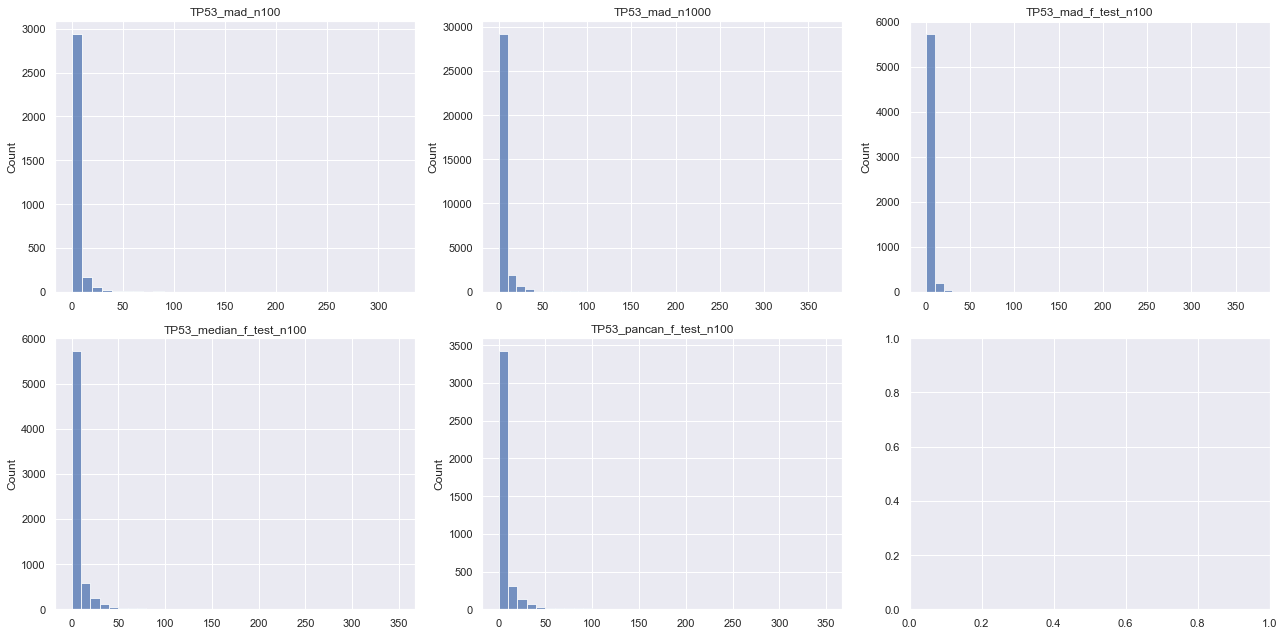

In [32]:
sns.set({'figure.figsize': (18, 9)})
sns.set_context('notebook')

fig, axarr = plt.subplots(2, 3)

for ix, (fs_method, f_stats_df) in enumerate(f_stats.items()):
    ax = axarr[ix // 3, ix % 3]
    dist_vals = (f_stats_df
        .loc[:, ~(f_stats_df.columns == 'pancan')]
        .values
        .flatten()
    )
    print(fs_method, dist_vals.shape)
    sns.histplot(dist_vals, ax=ax, binwidth=10)
    ax.set_title(fs_method)
    
plt.tight_layout()